In [1]:
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt

COUNT="count [-]"
PROJ = "SegmentsProj"
PROJORTHO=PROJ+"Ortho"
PROJLOXO=PROJ+"Loxo"
PROJORTHONOTLOXO=PROJORTHO+"NotLoxo"
PROJLOXONOTORTHO=PROJLOXO+"NotOrtho"
BASELINE = "SegmentsBaseline"
CONFLICT = "Conflict"

def read_detected(fname):
    df = pd.read_parquet(fname)
    if "date" not in df:
        df["date"]=df["start"].astype("datetime64[s]").dt.date
    df["length"]=df["stop"]-df["start"]
    df["datetime_start"] = df["start"].astype("datetime64[s]")#.dt.date
    df["datetime_stop"] = df["stop"].astype("datetime64[s]")#.dt.date
    return df.sort_values(["icao24","start"])


def extract_loxo_not_ortho(df,args):
    return df.query("iswhat=='loxodromy'").query("dolmax>=@args.dolmax").query("dlmax<@args.r*domax").query("dlmax<@args.r*dolmax")
def extract_ortho_not_loxo(df,args):
    return df.query("iswhat=='orthodromy'").query("dolmax>=@args.dolmax").query("domax<@args.r*dlmax").query("domax<@args.r*dolmax")

def extract_ortho(df):
    return df.query("iswhat=='orthodromy'")#.query("domax<100")#.query("domax<@args.r*dlmax")#.query("npts>10")#.query("dolmax>20")

def extract_loxo(df):
    return df.query("iswhat=='loxodromy'")#.query("domax<100")#.query("domax<@args.r*dlmax")#.query("npts>10")#.query("dolmax>20")

def isole_altitude_dataset(df):
    return df.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("length>30")

def intersection(l,q):
    start = max(q.start,l.start)
    end = min(l.stop,q.stop)
    return max(end-start,0.)

def union(l,q):
    start = min(q.start,l.start)
    end = max(l.stop,q.stop)
    return max(end-start,0.)

def is_included(l,q):
    return q.start<=l.start and l.stop <=q.stop

def inclusion_ratio(l,q):
    if is_included(l,q):
        return 1
    else:
        return intersection(l,q)/union(l,q)

def inclusion(l,q):# l C q ???
    if is_included(l,q):
        return 1
    else:
        inter=intersection(l,q)
        if inter==0:
            return 0
        else:       
            return inter/(l.stop-l.start)

def getkey(line):
    return (line.icao24,line.start,line.stop)

def map_key(d,f):
    res = {}
    for k,v in d.items():
        res[f[k]]=v
    return res

def update_line(d,af,qline,line,critname,newcrit):
    if newcrit > af.at[qline.name,d[critname]]:
        af.at[qline.name,d[critname]]=newcrit
        af.at[qline.name,d["key_"+critname]]=getkey(line)

def add_intersection(af,cf,suffix=""):
    res = {}
    d={p+k:p+k+suffix for k in ["iou","inclusion_ratio","inclusion"] for p in ["","key_"]}
    print(d)
    af[d["iou"]]=0.
    af[d["inclusion_ratio"]]=0.
    af[d["inclusion"]]=0.
    af[d["key_iou"]]=None
    af[d["key_inclusion_ratio"]]=None
    af[d["key_inclusion"]]=None
    for i,line in tqdm.tqdm(cf.iterrows()):
        k = getkey(line)
        res[k]=[]
        qf = af.query("date==@line.date").query("icao24==@line.icao24")
        for _, qline in qf.iterrows():
            leninter=intersection(qline,line)
            if leninter>0.:
                update_line(d,af,qline,line,"iou",leninter/union(qline,line))
                update_line(d,af,qline,line,"inclusion_ratio",inclusion_ratio(qline,line))
                update_line(d,af,qline,line,"inclusion",inclusion(qline,line))
                #af.loc[qline.name,d["iou"]]=max(leninter/union(qline,line),af.loc[qline.name,d["iou"]])
                #af.loc[qline.name,d["inclusion_ratio"]]=max(inclusion_ratio(qline,line),af.loc[qline.name,d["inclusion_ratio"]])
                #af.loc[qline.name,d["inclusion"]]=max(inclusion(qline,line),af.loc[qline.name,d["inclusion"]])
                res[k].append(qline)
    return res


In [2]:
import argparse

#args= argparse.Namespace(dolmax=40,r=0.5,detectedref = "/disk2/newjson/detectedref_alpha_l2_slope_3600_0.01_1_200_0.1_0.1",detectedother = "/disk2/newjson/detected_alpha_l2_slope_3600_0.01_0.5_0.1_0.01_0.1_0",conflict="/disk2/newjson/detectedref.parquet")
#args= argparse.Namespace(dolmax=40,r=0.5,detectedref = "/disk2/newjson/detectedref_alpha_l2_slope_3600_0.01_1_200_0.1_0.1",detectedother = "/disk2/newjson/detected_alpha_l2_slope_3600_0.01_0.5_0.1_0.001_0.1_20",conflict="/disk2/newjson/detectedref.parquet")
#args= argparse.Namespace(dolmax=40,r=0.5,detectedref = "/disk2/newjson/detectedref_alpha_l2_slope_3600_0.01_1_200_0.1_0.1",detectedother = "/disk2/newjson/detected_alpha_l2_slope_3600_0.01_0.5_0.1_0.002_0.1_0",conflict="/disk2/newjson/detectedref.parquet")
args= argparse.Namespace(dolmax=30,r=0.5,detectedref = "/disk2/newjson/detectedref_alpha_mean_slope_3600_0.01_1_200_0.1_0.1",detectedother = "/disk2/newjson/detected_alpha_mean_slope_3600_0.01_0.5_0.1_0.001_0.1_0",conflict="/disk2/newjson/detectedref.parquet")
ref = read_detected(args.detectedref)
other = read_detected(args.detectedother)#.query("lever<0.01")
print(f"{ref.shape=}")
print(f"{other.shape=}")
d = {k:isole_altitude_dataset(v) for k,v in {BASELINE:ref,PROJ:other}.items()}
d[PROJORTHO]=extract_ortho(d[PROJ])
d[PROJLOXO]=extract_loxo(d[PROJ])
d[PROJORTHONOTLOXO]=extract_ortho_not_loxo(d[PROJ],args)
d[PROJLOXONOTORTHO]=extract_loxo_not_ortho(d[PROJ],args)
d[CONFLICT]=read_detected(args.conflict)
print(f"{d[BASELINE].shape=}")
print(f"{d[PROJORTHO].shape=}")
print(f"{d[BASELINE].length.describe()=}")
print(f"{d[PROJORTHO].length.describe()=}")
print(f"{d[CONFLICT].length.describe()=}")
print(f"{other.query("iswhat=='orthodromy'").altitude_start.describe()=}")
print(f"{other.query("iswhat=='loxodromy'").altitude_start.describe()=}")
del d[PROJ]
add_intersection(d[BASELINE],d[PROJORTHO],suffix=PROJORTHO)
add_intersection(d[PROJORTHO],d[BASELINE],suffix=BASELINE)

ref.shape=(13149, 43)
other.shape=(28269, 37)
d[BASELINE].shape=(10191, 43)
d[PROJORTHO].shape=(11548, 37)
d[BASELINE].length.describe()=count    10191.000000
mean       529.066627
std        482.491944
min         31.000000
25%        154.000000
50%        380.000000
75%        760.000000
max       3287.000000
Name: length, dtype: float64
d[PROJORTHO].length.describe()=count    11548.000000
mean       486.647991
std        404.921006
min         31.000000
25%        202.000000
50%        347.000000
75%        638.000000
max       2721.000000
Name: length, dtype: float64
d[CONFLICT].length.describe()=count    3816.000000
mean      347.135482
std       268.844515
min        31.000000
25%        92.750000
50%       314.000000
75%       526.000000
max      2043.000000
Name: length, dtype: float64
other.query("iswhat=='orthodromy'").altitude_start.describe()=count    14087.000000
mean     35324.960957
std       4247.913938
min        625.000000
25%      35000.000000
50%      37000.000000
7

11548it [02:11, 87.85it/s]


{'iou': 'iouSegmentsBaseline', 'key_iou': 'key_iouSegmentsBaseline', 'inclusion_ratio': 'inclusion_ratioSegmentsBaseline', 'key_inclusion_ratio': 'key_inclusion_ratioSegmentsBaseline', 'inclusion': 'inclusionSegmentsBaseline', 'key_inclusion': 'key_inclusionSegmentsBaseline'}


10191it [01:51, 91.33it/s] 


{('010154',
  1660043436,
  1660044020): [iswhat                                          orthodromy
  dolmax                                          365.530979
  domax                                            20.846038
  dlmax                                           377.340839
  domean                                            8.782536
  dlmean                                          254.411285
  v                                                148.19827
  maxangle                                        148.291389
  minangle                                        148.085419
  stdangle                                          0.033633
  meanabsangleerror                                   0.0248
  lever                                              0.01303
  start                                           1660043419
  stop                                            1660044018
  npts                                                   572
  icao24                                     

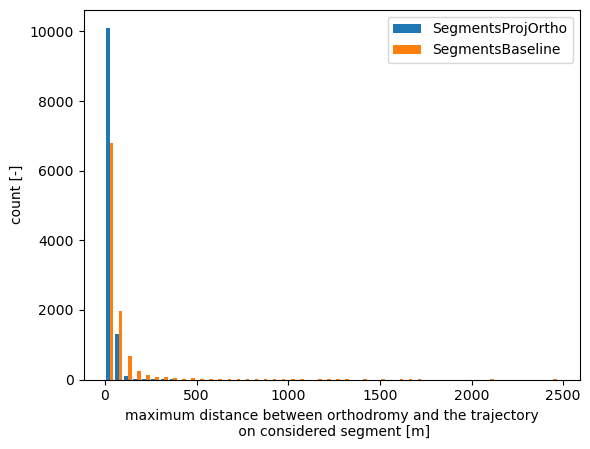

In [3]:

def plothist(d_ortho,vstr,ystr,bins=50):
    if isinstance(vstr,str):
        plt.hist(tuple(v[vstr] for k,v in d_ortho.items()),bins=bins)
    else:
        plt.hist(tuple(v[vstr[k]] for k,v in d_ortho.items()),bins=bins)
    plt.xlabel(ystr)
    plt.ylabel(COUNT)
    plt.gca().legend(list(d_ortho.keys()))
plothist({k:d[k] for k in [PROJORTHO,BASELINE]},"domax","maximum distance between orthodromy and the trajectory\n on considered segment [m]")

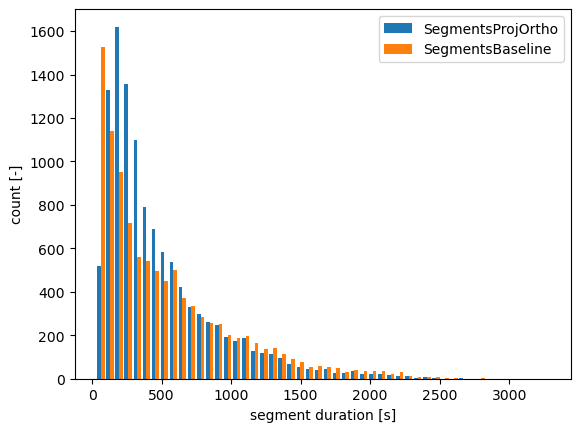

In [4]:
plothist({k:d[k] for k in [PROJORTHO,BASELINE]},"length","segment duration [s]")

0.6762465373961218
0.592728383745799
0.6035603274280993
0.5467951322374791


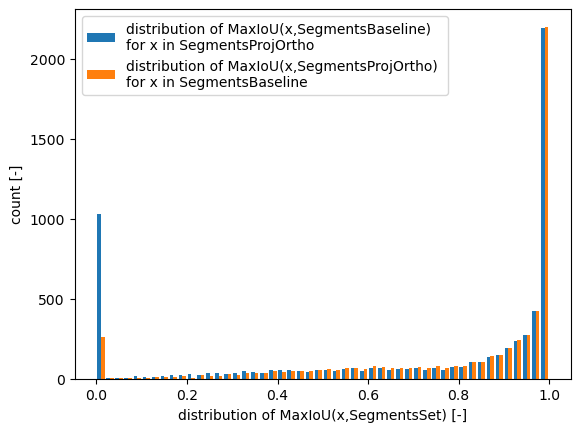

In [5]:

f = {
    PROJORTHO:f"distribution of MaxIoU(x,{BASELINE}) \nfor x in {PROJORTHO}",
    BASELINE:f"distribution of MaxIoU(x,{PROJORTHO}) \nfor x in {BASELINE}",
    }
iou={
    PROJORTHO:BASELINE,
    BASELINE:PROJORTHO,
}
plothist({f[k]:d[k].query("length>300")for k in [PROJORTHO,BASELINE]},{f[k]:f"iou{iou[k]}" for k in [PROJORTHO,BASELINE]},"distribution of MaxIoU(x,SegmentsSet) [-]")
print(np.mean(d[BASELINE].query("length>300")[f"iou{PROJORTHO}"]>0.8))
print(np.mean(d[PROJORTHO].query("length>300")[f"iou{BASELINE}"]>0.8))
print(np.mean(d[BASELINE][f"iou{PROJORTHO}"]))
print(np.mean(d[PROJORTHO][f"iou{BASELINE}"]))

{'iou': 'iouSegmentsProjLoxo', 'key_iou': 'key_iouSegmentsProjLoxo', 'inclusion_ratio': 'inclusion_ratioSegmentsProjLoxo', 'key_inclusion_ratio': 'key_inclusion_ratioSegmentsProjLoxo', 'inclusion': 'inclusionSegmentsProjLoxo', 'key_inclusion': 'key_inclusionSegmentsProjLoxo'}


12021it [02:27, 81.41it/s]


{'iou': 'iouSegmentsProjOrtho', 'key_iou': 'key_iouSegmentsProjOrtho', 'inclusion_ratio': 'inclusion_ratioSegmentsProjOrtho', 'key_inclusion_ratio': 'key_inclusion_ratioSegmentsProjOrtho', 'inclusion': 'inclusionSegmentsProjOrtho', 'key_inclusion': 'key_inclusionSegmentsProjOrtho'}


11548it [02:04, 92.51it/s]


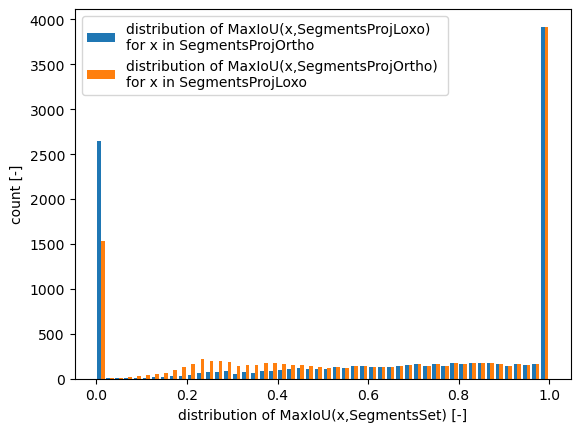

In [6]:
add_intersection(d[PROJORTHO],d[PROJLOXO],suffix=PROJLOXO)
add_intersection(d[PROJLOXO],d[PROJORTHO],suffix=PROJORTHO)
settocompare=[PROJORTHO,PROJLOXO]
f = {
    PROJORTHO:f"distribution of MaxIoU(x,{PROJLOXO}) \nfor x in {PROJORTHO}",
    PROJLOXO:f"distribution of MaxIoU(x,{PROJORTHO}) \nfor x in {PROJLOXO}",
    }
iou={
    PROJORTHO:PROJLOXO,
    PROJLOXO:PROJORTHO,
}
plothist({f[k]:d[k]for k in settocompare},{f[k]:f"iou{iou[k]}" for k in settocompare},"distribution of MaxIoU(x,SegmentsSet) [-]")    

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2056540/307237013.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("track $[^\circ]$")
/tmp/ipykernel_2056540/307237013.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res=df.groupby(pd.cut(df.track_start,bins=36))[f"iou{PROJORTHO}"].mean()


Text(0, 0.5, 'MaxIoU(x,SegmentsProjOrtho) for x in SegmentsProjLoxo\n averaged in each track bin')

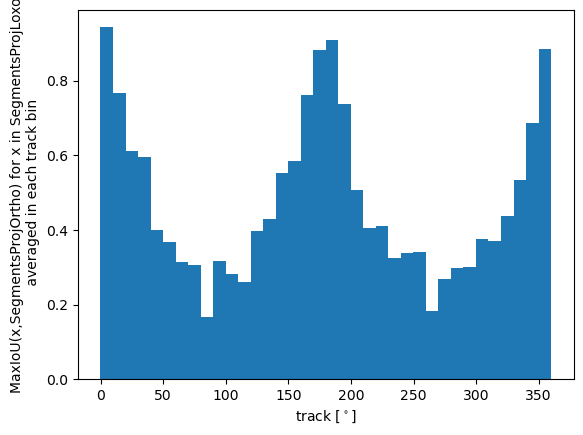

In [7]:
df=d[PROJLOXO]
res=df.groupby(pd.cut(df.track_start,bins=36))[f"iou{PROJORTHO}"].mean()
n=res.index.categories.left.shape[0]
x=np.zeros(1+n)
x[:-1]=res.index.categories.left
x[-1]=res.index.categories.right[-1]
plt.stairs(res.values,x,fill=True)
plt.xlabel("track $[^\circ]$")
ystr=f"MaxIoU(x,{PROJORTHO}) for x in {PROJLOXO}\n averaged in each track bin"
plt.ylabel(ystr)
#plt.gca().legend((ystr,))

/tmp/ipykernel_2056540/3038209705.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res=df.groupby(pd.cut(df.dolmax,bins=20))[f"iou{PROJORTHO}"].mean()


Text(0, 0.5, 'MaxIoU(x,SegmentsProjOrtho) for x in SegmentsProjLoxo\n averaged in each distance bin')

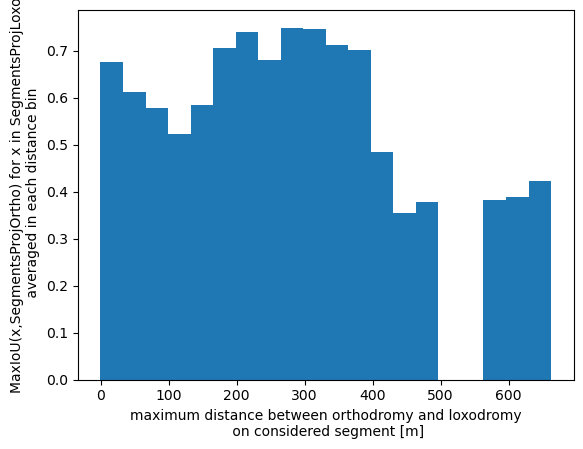

In [8]:
df=d[PROJLOXO]
res=df.groupby(pd.cut(df.dolmax,bins=20))[f"iou{PROJORTHO}"].mean()
n=res.index.categories.left.shape[0]
x=np.zeros(1+n)
x[:-1]=res.index.categories.left
x[-1]=res.index.categories.right[-1]
plt.stairs(res.values,x,fill=True)
plt.xlabel("maximum distance between orthodromy and loxodromy\n on considered segment [m]")
ystr=f"MaxIoU(x,{PROJORTHO}) for x in {PROJLOXO}\n averaged in each distance bin"
plt.ylabel(ystr)
#plt.gca().legend((ystr,))

In [9]:
add_intersection(d[PROJLOXONOTORTHO],d[CONFLICT],suffix=CONFLICT)
add_intersection(d[PROJORTHONOTLOXO],d[CONFLICT],suffix=CONFLICT)

{'iou': 'iouConflict', 'key_iou': 'key_iouConflict', 'inclusion_ratio': 'inclusion_ratioConflict', 'key_inclusion_ratio': 'key_inclusion_ratioConflict', 'inclusion': 'inclusionConflict', 'key_inclusion': 'key_inclusionConflict'}


3816it [00:35, 106.28it/s]


{'iou': 'iouConflict', 'key_iou': 'key_iouConflict', 'inclusion_ratio': 'inclusion_ratioConflict', 'key_inclusion_ratio': 'key_inclusion_ratioConflict', 'inclusion': 'inclusionConflict', 'key_inclusion': 'key_inclusionConflict'}


3816it [00:36, 104.47it/s]


{('010154', 1660044025, 1660044061): [],
 ('020025', 1659373618, 1659373649): [],
 ('020025', 1659726417, 1659727296): [],
 ('020044', 1658581580, 1658581769): [],
 ('020044', 1659011805, 1659012217): [],
 ('020044', 1659681670, 1659681796): [],
 ('020057', 1657913886, 1657914166): [],
 ('020057', 1658664398, 1658664685): [],
 ('020058', 1657991709, 1657992305): [],
 ('020058', 1658160506, 1658160848): [],
 ('020058', 1658341872, 1658342460): [],
 ('020066', 1657992449, 1657992539): [],
 ('020066', 1658156540, 1658156774): [],
 ('020066', 1659537115, 1659537552): [],
 ('020066', 1659633911, 1659634072): [],
 ('020066', 1660159331, 1660159363): [],
 ('02006e', 1659267082, 1659267512): [],
 ('02006f', 1657890449, 1657890851): [],
 ('02006f', 1657915001, 1657915136): [],
 ('02006f', 1659978821, 1659979072): [],
 ('020073', 1658085689, 1658085847): [],
 ('020073', 1658589343, 1658589833): [],
 ('02007a', 1658770585, 1658770678): [],
 ('02008b', 1658059371, 1658059406): [],
 ('020092', 1658

Text(0, 0.5, 'count [-]')

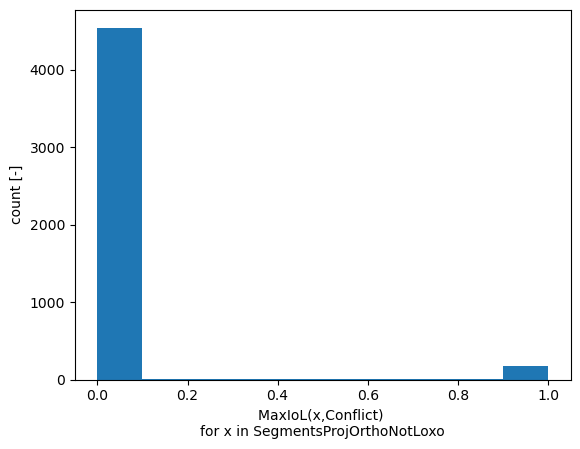

In [10]:
#plt.hist((isole_altitude_dataset(pc).query("dolmax>=20").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax").inclusionconflict))#>0.).astype(int))
plt.hist(d[PROJORTHONOTLOXO][f"inclusion_ratio{CONFLICT}"])
plt.xlabel(f"MaxIoL(x,{CONFLICT}) \nfor x in {PROJORTHONOTLOXO}")
plt.ylabel(COUNT)

Text(0.5, 0, 'MaxIoL(x,Conflict) \nfor x in SegmentsProjLoxoNotOrtho')

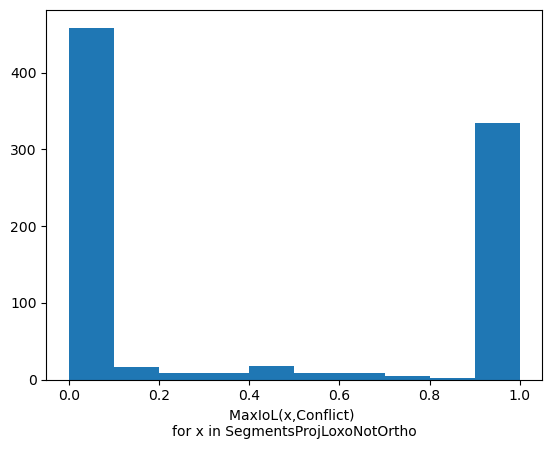

In [11]:
#plt.hist((isole_altitude_dataset(pc).query("dolmax>=20").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax").inclusionconflict))#>0.).astype(int))
plt.hist(d[PROJLOXONOTORTHO][f"inclusion_ratio{CONFLICT}"])
plt.xlabel(f"MaxIoL(x,{CONFLICT}) \nfor x in {PROJLOXONOTORTHO}")

In [12]:
add_intersection(d[PROJORTHONOTLOXO],d[PROJLOXONOTORTHO],suffix=PROJLOXONOTORTHO)
add_intersection(d[PROJLOXONOTORTHO],d[PROJORTHONOTLOXO],suffix=PROJORTHONOTLOXO)

{'iou': 'iouSegmentsProjLoxoNotOrtho', 'key_iou': 'key_iouSegmentsProjLoxoNotOrtho', 'inclusion_ratio': 'inclusion_ratioSegmentsProjLoxoNotOrtho', 'key_inclusion_ratio': 'key_inclusion_ratioSegmentsProjLoxoNotOrtho', 'inclusion': 'inclusionSegmentsProjLoxoNotOrtho', 'key_inclusion': 'key_inclusionSegmentsProjLoxoNotOrtho'}


869it [00:09, 88.24it/s]


{'iou': 'iouSegmentsProjOrthoNotLoxo', 'key_iou': 'key_iouSegmentsProjOrthoNotLoxo', 'inclusion_ratio': 'inclusion_ratioSegmentsProjOrthoNotLoxo', 'key_inclusion_ratio': 'key_inclusion_ratioSegmentsProjOrthoNotLoxo', 'inclusion': 'inclusionSegmentsProjOrthoNotLoxo', 'key_inclusion': 'key_inclusionSegmentsProjOrthoNotLoxo'}


4772it [00:49, 96.21it/s] 


{('010154', 1660043419, 1660044018): [],
 ('010154', 1660044229, 1660044955): [],
 ('010154', 1660045061, 1660045580): [],
 ('020025', 1659372417, 1659372644): [],
 ('020025', 1659372751, 1659373600): [],
 ('020025', 1659727426, 1659727946): [],
 ('020044', 1658581944, 1658583654): [],
 ('020044', 1659011271, 1659011719): [],
 ('020057', 1657914361, 1657914706): [],
 ('020058', 1657990741, 1657991009): [],
 ('020058', 1657992810, 1657993210): [],
 ('020058',
  1658160875,
  1658162641): [iswhat                                                   loxodromy
  dolmax                                                  132.248011
  domax                                                   148.490682
  dlmax                                                    47.620944
  domean                                                   80.479231
  dlmean                                                   15.015061
  v                                                      -116.352349
  maxangle                

In [13]:
np.mean(d[PROJLOXONOTORTHO][f"iou{CONFLICT}"]>0.5)

np.float64(0.27848101265822783)

In [49]:
af=d[PROJLOXONOTORTHO].query(f"inclusion{CONFLICT}>0.99").query("length>300")
af

,iswhat,dolmax,domax,dlmax,domean,dlmean,v,maxangle,minangle,stdangle,...,inclusionConflict,key_iouConflict,key_inclusion_ratioConflict,key_inclusionConflict,iouSegmentsProjOrthoNotLoxo,inclusion_ratioSegmentsProjOrthoNotLoxo,inclusionSegmentsProjOrthoNotLoxo,key_iouSegmentsProjOrthoNotLoxo,key_inclusion_ratioSegmentsProjOrthoNotLoxo,key_inclusionSegmentsProjOrthoNotLoxo
1921,loxodromy,96.965346,137.352854,7.517172,94.339116,2.535115,-151.302448,-151.079831,-151.577169,0.114609,...,1.0,"(020058, 1657991709, 1657992305)","(020058, 1657991709, 1657992305)","(020058, 1657991709, 1657992305)",0.000000,0.000000,0.000000,None,None,None
17857,loxodromy,137.542614,169.301315,5.838523,104.823168,1.470104,-148.446036,-148.208778,-148.618653,0.080747,...,1.0,"(020092, 1659280285, 1659280817)","(020092, 1659280285, 1659280817)","(020092, 1659280285, 1659280817)",0.000000,0.000000,0.000000,None,None,None
22849,loxodromy,64.190874,102.937680,6.375728,58.553340,1.570793,55.018115,55.223234,54.851353,0.081105,...,1.0,"(020092, 1659705342, 1659706496)","(020092, 1659705342, 1659706496)","(020092, 1659705342, 1659706496)",0.413333,0.413333,0.611842,"(020092, 1659705610, 1659705942)","(020092, 1659705610, 1659705942)","(020092, 1659705610, 1659705942)"
2693,loxodromy,54.382177,97.874079,5.392062,60.556257,1.627493,-108.763930,-108.516306,-108.943675,0.102210,...,1.0,"(0200ae, 1658062582, 1658063080)","(0200ae, 1658062582, 1658063080)","(0200ae, 1658062582, 1658063080)",0.000000,0.000000,0.000000,None,None,None
18570,loxodromy,103.544019,88.488235,35.290718,57.716506,13.719152,28.012069,28.204857,27.807847,0.090781,...,1.0,"(0200d2, 1659349109, 1659349591)","(0200d2, 1659349109, 1659349591)","(0200d2, 1659349109, 1659349591)",0.000000,0.000000,0.000000,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,loxodromy,102.349743,92.030825,41.718692,53.389798,17.883658,-150.316790,-150.126298,-150.590393,0.116212,...,1.0,"(502d0d, 1658470192, 1658470834)","(502d0d, 1658470192, 1658470834)","(502d0d, 1658470192, 1658470834)",0.000000,0.000000,0.000000,None,None,None
18122,loxodromy,110.742412,137.974258,37.036849,69.170107,9.876826,-155.708852,-155.567434,-156.017608,0.115112,...,1.0,"(502d33, 1659299736, 1659300498)","(502d33, 1659299736, 1659300498)","(502d33, 1659299736, 1659300498)",0.242718,0.242718,0.362319,"(502d33, 1659299695, 1659299990)","(502d33, 1659299695, 1659299990)","(502d33, 1659299695, 1659299990)"
5641,loxodromy,160.095028,204.481879,7.111198,136.517748,2.161644,180.536103,180.773948,180.313540,0.099442,...,1.0,"(aa4548, 1658326352, 1658327028)","(aa4548, 1658326352, 1658327028)","(aa4548, 1658326352, 1658327028)",0.000000,0.000000,0.000000,None,None,None
19592,loxodromy,204.257032,283.027612,9.026798,181.372427,2.685830,182.651324,182.851442,182.357510,0.119349,...,1.0,"(aa57df, 1659434963, 1659435922)","(aa57df, 1659434963, 1659435922)","(aa57df, 1659434963, 1659435922)",0.000000,0.000000,0.000000,None,None,None


In [23]:
d[CONFLICT]["key"]=[getkey(line) for i,line in d[CONFLICT].iterrows()]

In [50]:

caf = af.merge(d[CONFLICT],left_on=f"key_inclusion{CONFLICT}",right_on="key",suffixes=("","conf"))
caf["shifted"]=caf["datetime_startconf"]+pd.Timedelta(10,unit="s")
caf=caf.query('datetime_start>=shifted')#.query("dlmax<30")
caf.shape

(201, 62)

<Axes: >

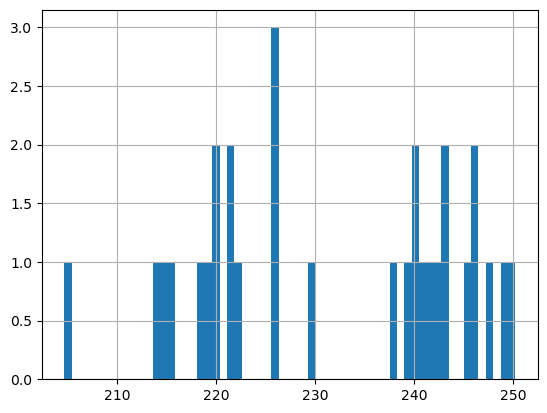

In [58]:
caf.query("abs(track_stop-track_angle)<1")[["dolmax","dlmax","domax","track_angle","track_start","track_stop","lever"]]#.hist(bins=60)
#plt.scatter(caf.track_start,caf.track_angle)
#(caf.query("lever<0.03").track_start-caf.query("lever<0.03").track_angle).hist(bins=60)
(caf.query("200<track_start<260").query("lever<0.03").track_stop).hist(bins=61)
#caf
#caftrack_start.hist(bins=350)

In [18]:
np.mean(d[PROJORTHONOTLOXO][f"iou{PROJLOXONOTORTHO}"]>0)

np.float64(0.03625314333612741)

In [19]:
from sklearn import tree
model = tree.DecisionTreeClassifier(ccp_alpha=0.00005)
X=["track_start","domax","dlmax","dolmax","length","slope"]
model.fit(df[X],df.iou==0)

AttributeError: 'DataFrame' object has no attribute 'iou'

In [ ]:
tree.plot_tree(model)

In [ ]:
model.predict(df[X])

In [ ]:
conflict =read_detected(args.conflict)
#PROJORTHO = "SegmentsProjOrtho"
#PROJLOXO = "SegmentsProjLoxo"
#d_ortho_loxo = {PROJLOXO:extract_loxo(d[PROJORTHO],args),PROJORTHO:extract_ortho(d[PROJORTHO],args)}
#add_intersection(d_ortho_loxo[PROJLOXO],d_ortho_loxo[PROJORTHO],suffix="matchortho")
#add_intersection(d_ortho_loxo[PROJLOXO],conflict,suffix="conflict")             
#add_intersection(d_ortho_loxo[PROJORTHO],conflict,suffix="conflict")
list(conflict)

In [ ]:
baseline =d[BASELINE].reset_index(drop=True)#.query("altitude_start>20000").query("altitude_stop>20000").query("abs(altitude_stop-altitude_start)<500")
add_intersection(baseline,conflict,suffix="conflict")

In [ ]:
np.sum(baseline.iouconflict>0)

In [ ]:
pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").lever.describe()

In [ ]:
plt.hist((isole_altitude_dataset(pc).query("dolmax>=20").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax").inclusionconflict))#>0.).astype(int))

In [ ]:
y=pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("dolmax>=100").query("dlmax<0.1*domax").query("length>100").query("dlmax<0.1*dolmax").query("inclusionconflict==1")
np.sort(y.track_start)#-y.track_stop)

In [ ]:
add_intersection(conflict,pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("dolmax>=20").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax"),suffix="conf")

In [ ]:
print(np.sum(conflict.iouconf>0))
plt.hist(conflict.iouconf)

In [ ]:
add_intersection(d_ortho_loxo[PROJORTHO],conflict,suffix="conflict")

In [ ]:
plt.hist((d_ortho_loxo[PROJORTHO].query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("dolmax>=20").query("domax<0.5*dlmax").query("domax<0.5*dolmax").iouconflict))

In [ ]:
sel=pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("dolmax>550").query("dlmax<0.25*domax").query("dlmax<0.25*dolmax")
sel[['dolmax','domax','dlmax','icao24','start','stop','track_start','length','npts','datetime_start','altitude_start','slope','lever']]

In [ ]:
d[PROJORTHO].query("icao24=='3c64ae'")[['iswhat','dolmax','domax','dlmax','icao24','start','stop','track_start','length','npts','datetime_start','datetime_stop','altitude_start','slope','lever']]

In [ ]:
import importlib
import geosphere #import the module here, so that it can be reloaded.
importlib.reload(geosphere)
traj=pd.read_parquet("/disk2/newjson/trajs/2022-07-24.parquet")
traj["tunix"]=traj["timestamp"].astype(int)//10**9
h=1000
tpb = traj.query("icao24=='3c64ae'").query("1658654618-@h<=tunix<=1658655505+@h")
plt.scatter(tpb.timestamp,tpb.track)
h=0
tpb = traj.query("icao24=='3c64ae'").query("1658654618-@h<=tunix<=1658655505+@h")
lats=tpb.latitude.values
lons=tpb.longitude.values
dist=geosphere.my_distance_loxo(lats[0],lons[0],lats[-1],lons[-1],lats,lons,nptsfactor=50)
plt.scatter(tpb.timestamp,tpb.track)
plt.show()
plt.scatter(np.arange(len(dist)),dist)


In [ ]:
conflict.query("icao24=='3c64ae'")

In [ ]:
sel=pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<200").query("dolmax>250").query("lever<0.021").query("dlmax<0.25*domax").query("dlmax<0.25*dolmax")
sel[['dolmax','domax','dlmax','icao24','start','stop','track_start','length','npts','datetime_start','altitude_start','slope','lever','iouconflict']]

In [ ]:
traj=pd.read_parquet("/disk2/newjson/trajs/2022-07-18.parquet")
traj["tunix"]=traj["timestamp"].astype(int)//10**9
h=1000
tpb = traj.query("icao24=='4070eb'").query("1658131121-@h<=tunix<=1658131967+@h")
plt.scatter(tpb.timestamp,tpb.track)
#1658130877	1658131101
h=0
tpb = traj.query("icao24=='4070eb'").query("1658131121-@h<=tunix<=1658131967+@h")
plt.scatter(tpb.timestamp,tpb.track)

In [ ]:
conflict.query("icao24=='4070eb'")

In [ ]:
d[BASELINE].query("icao24=='4070eb'")[["start","stop","dolmax","domax","dlmax"]]

In [ ]:
plt.scatter(tpb.timestamp,tpb.altitude)

In [ ]:
pc["prediou"]=model.predict(pc[X])
plt.hist((pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<500").query("prediou==0.").iouconflict))#.astype(int))

In [ ]:
from sklearn import tree
model = tree.DecisionTreeClassifier(ccp_alpha=0.002)
pc=pc.query("altitude_start>20000").query("altitude_stop>20000").query("abs(altitude_stop-altitude_start)<500")
pc["absslope"]=np.abs(pc.slope)
pc["track_eastwest"]=np.minimum(np.abs(pc.track_start-90),np.abs(pc.track_start-270))
X=["track_eastwest","dolmax","absslope","dlmax"]
model.fit(pc[X],pc.iouconflict>0.)
tree.plot_tree(model)

In [ ]:
np.mean(pc.query("altitude_start>20000").query("altitude_stop>20000").query("abs(altitude_stop-altitude_start)<500").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax").query("dolmax>100").query("250<=track_start<=290").iouconflict>0)

In [ ]:
np.mean(pc.query("altitude_start>=20000").query("altitude_stop>=20000").query("abs(altitude_stop-altitude_start)<500").query("abs(slope)<1e-4").query("dolmax>50").iouconflict>0)

In [ ]:
conflict.length.describe()

In [ ]:
pc.loc[pc["dlmax"].idxmax()]

In [ ]:
pc.query("altitude_start>20000").query("altitude_stop>20000").query("dlmax<0.5*domax").query("dlmax<0.5*dolmax").length.describe()

In [ ]:
d[PROJORTHO].loc[d[PROJORTHO]["domax"].idxmax()]